# Simulating MaSp2 Production Limits (Four Repeats)

## 1. Load the python packages

In [1]:
from __future__ import print_function, division, absolute_import

# python imports
import re
from os.path import join
from collections import defaultdict
import pickle
import pandas as pd

# third party imports
import pandas
import tabulate
import cobra
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',100)
pd.set_option('display.max_colwidth',300)

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
#from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/solvers/__init__.py:63: UserWarning: No LP solvers found
  warn("No LP solvers found")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


## 2. Load the iJL1678b model

Load the iJL1678b model in pickle format that is located in the current directory.

In [2]:
with open('iJL1678b.pickle', 'rb') as f:
    me = pickle.load(f)

## 3. Define ME-Model Solve Functions

In [3]:
def solve_me_model(me, max_mu, precision=1e-6, min_mu=0, using_soplex=False,
                  compiled_expressions=None):
    if using_soplex:
        from cobrame.solve.algorithms import binary_search
        binary_search(me, min_mu=min_mu, max_mu=max_mu, debug=True, mu_accuracy=precision,
                      compiled_expressions=compiled_expressions)
    else:
        from qminospy.me1 import ME_NLP1
        # The object containing solveME methods--composite that uses a ME model object 
        me_nlp = ME_NLP1(me, growth_key='mu')
        # Use bisection for now (until the NLP formulation is worked out)
        muopt, hs, xopt, cache = me_nlp.bisectmu(precision=precision, mumax=max_mu)
        me.solution.f = me.solution.x_dict['biomass_dilution']
        
def show_escher_map(me, solution=None):
    import escher
    view = escher.Builder("iJO1366.Central metabolism")
    view.reaction_data = me.get_metabolic_flux(solution=solution)
    return view

## 4. Create the MaSp2 Transcription Reaction

Complete the steps necessary to create the MaSp2 Transcription Reaction

In [4]:
locus_id = 'MaSp2'
left_pos =  None
right_pos = None
seq = 'AAACTGCACATGACCGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGTCTGGTGGTGACAAACTGCACATGACCGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGTCTGGTGGTGACAAACTGCACATGACCGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGTCTGGTGGTGACAAACTGCACATGACCGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGTCTGGTGGTGAC'
strand = None
rna_type = 'mRNA'

building.create_transcribed_gene(me, locus_id, rna_type, seq)
building.add_transcription_reaction(me, 'TU_MaSp2', {'MaSp2'}, seq)
print(me.reactions.transcription_TU_MaSp2.reaction)
me.reactions.transcription_TU_MaSp2.update()

740 atp_c + 2040 ctp_c + 1120 gtp_c + 288 utp_c --> RNA_MaSp2 + 1336.7666654680002 mRNA_biomass + 4188 ppi_c


/source/cobrame/cobrame/core/reaction.py:852 UserWarning: RNA Polymerase () not found


###  Add the RNAP to the MaSp1 Transcription Reaction

In [5]:
me.reactions.transcription_TU_MaSp2.transcription_data.RNA_polymerase = 'RNAP70-CPLX'
me.reactions.transcription_TU_MaSp2.update()

List the transcription data ("transcription_data") associated with the MaSp2 transcription reaction ("transcription_TU_MaSp2").

In [6]:
rxn = me.reactions.transcription_TU_MaSp2
data = rxn.transcription_data
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,TU_MaSp2
_model,iJL1678b-ME
_parent_reactions,{'transcription_TU_MaSp2'}
nucleotide_sequence,AAACTGCACATGACCGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGTCTGGTCCGGGTTCTGCGGCGGCGGCGGCGGCGGCGGCGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGGTTACGGTCCGGGTCAGCAGGGTCCGGGTGG...
RNA_products,{'RNA_MaSp2'}
RNA_polymerase,RNAP70-CPLX
subreactions,"defaultdict(<class 'int'>, {})"


List the attributes of the MaSp2 transcription reaction.

In [7]:
rxn = me.reactions.transcription_TU_MaSp2
data = rxn
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,transcription_TU_MaSp2
name,
notes,{}
annotation,{}
_gene_reaction_rule,
subsystem,
_genes,set()
_metabolites,"{<RNAP RNAP70-CPLX at 0x7f09074b7390>: -0.0200139236828019*mu - 0.00783545112181693, <TranscribedGene RNA_MaSp2 at 0x7f09075e2550>: 1, <Metabolite utp_c at 0x7f09074b7e10>: -288, <Metabolite atp_c at 0x7f09074b79b0>: -740, <Metabolite ctp_c at 0x7f09074b7ef0>: -2040, <Metabolite gtp_c at 0x7f090..."
_model,iJL1678b-ME
_objective_coefficient,0.0


List the complete reaction associated with the MaSp1 transcription reaction.

In [8]:
me.reactions.get_by_id('transcription_TU_MaSp2').reaction

'0.0200139236828019*mu + 0.00783545112181693 RNAP70-CPLX + 740 atp_c + 2040 ctp_c + 1120 gtp_c + 288 utp_c --> RNA_MaSp2 + 1336.7666654680002 mRNA_biomass + 4188 ppi_c'

List the RNAP associated with the MaSp2 transcription reaction

In [9]:
me.reactions.transcription_TU_MaSp2.transcription_data.RNA_polymerase

'RNAP70-CPLX'

## 5. Create the MaSp2 Translation Reaction

Complete all the steps necessary to create the MaSp2 Translation Reaction

### Storing information about a translation reaction

In [10]:
data = cobrame.TranslationData('MaSp2', me, 'RNA_MaSp2', 'protein_MaSp2')
data.nucleotide_sequence = seq

### Create translation reaction

By associating the TranslationReaction with its corresponding TranslationData object and running the update function, COBRAme will create a translation reaction for the nucleotide sequence given based on the organisms codon table and prespecified translation machinery.

In [11]:
rxn = cobrame.TranslationReaction('translation_MaSp2')
rxn.translation_data = data
me.add_reaction(rxn)

### Updating the translation reaction

Note that this process does not include the ribosome in the reaction.

In [12]:
rxn.update()
print(rxn.reaction)

0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_MaSp2 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 288 ala__L_c + 4 asp__L_c + 6.26039780521262*(mu + 0.3915)/mu atp_c + 192 gln__L_c + 512 gly_c + 4 his__L_c + 4 leu__L_c + 3 lys__L_c + 7.9949282049938*(mu + 0.3915)/mu mRNA_biomass + 5 met__L_c + 236 pro__L_c + 0.0200139236828019*mu + 0.00783545112181693 ribosome + 76 ser__L_c + 4 thr__L_c + 68 tyr__L_c --> 6.26039780521262*(mu + 0.3915)/mu adp_c + 4.42578875171468*(mu + 0.3915)/mu amp_c + 12.2008230452675*(mu + 0.3915)/mu cmp_c + 6.69849108367627*(mu + 0.3915)/mu gmp_c + 1395.0 - 6.26039780521262*(mu + 0.3915)/mu h2o_c + 6.26039780521262*(mu + 0.3915)/mu h_c + 6.26039780521262*(mu + 0.3915)/mu pi_c + protein_MaSp2 + 117.83781752 protein_biomass + 1.72246913580247*(mu + 0.3915)/mu ump_c


### Incorporate the ribosome

Add the ribosome to the reaction.

In [13]:
ribosome = cobrame.Ribosome('ribosome')
me.add_metabolites([ribosome])
me.reactions.translation_MaSp2.update()
print(me.reactions.translation_MaSp2.reaction)

0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_MaSp2 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 288 ala__L_c + 4 asp__L_c + 6.26039780521262*(mu + 0.3915)/mu atp_c + 192 gln__L_c + 512 gly_c + 4 his__L_c + 4 leu__L_c + 3 lys__L_c + 7.9949282049938*(mu + 0.3915)/mu mRNA_biomass + 5 met__L_c + 236 pro__L_c + 0.0200139236828019*mu + 0.00783545112181693 ribosome + 76 ser__L_c + 4 thr__L_c + 68 tyr__L_c --> 6.26039780521262*(mu + 0.3915)/mu adp_c + 4.42578875171468*(mu + 0.3915)/mu amp_c + 12.2008230452675*(mu + 0.3915)/mu cmp_c + 6.69849108367627*(mu + 0.3915)/mu gmp_c + 1395.0 - 6.26039780521262*(mu + 0.3915)/mu h2o_c + 6.26039780521262*(mu + 0.3915)/mu h_c + 6.26039780521262*(mu + 0.3915)/mu pi_c + protein_MaSp2 + 117.83781752 protein_biomass + 1.72246913580247*(mu + 0.3915)/mu ump_c


### Add Subreactions to the MaSp2 model

Create the subreactions that represent elongation, initiation and termination

In [14]:
elongation = ['FusA_mono_elongation', 'Tuf_gtp_regeneration']
initiation = ['Translation_gtp_initiation_factor_InfB', 'Translation_initiation_factor_InfA', 
              'Translation_initiation_factor_InfC', 'fmet_addition_at_START', 'peptide_deformylase_processing', 
              'peptide_chain_release', 'ribosome_recycler']
termination = {'UGA':'PrfB_mono'}
me.process_data.get_by_id('MaSp2').add_elongation_subreactions(elongation_subreactions=set(elongation))
me.process_data.get_by_id('MaSp2').add_initiation_subreactions(start_codons=set(['AUG']), start_subreactions=set(initiation))
me.process_data.get_by_id('MaSp2').add_termination_subreactions(translation_terminator_dict=termination)
#me.reactions.translation_MaSp2.update(verbose=False)

/source/cobrame/cobrame/core/processdata.py:859 UserWarning: RNA_MaSp2 starts with 'AAA' which is not a start codon
/source/cobrame/cobrame/core/processdata.py:896 UserWarning: No termination enzyme for RNA_MaSp2


List the subreactions associated with MaSp2 translation reaction stored in the ProcessData.

In [15]:
me.process_data.get_by_id('MaSp2').subreactions

defaultdict(int,
            {'FusA_mono_elongation': 1395.0,
             'Tuf_gtp_regeneration': 1395.0,
             'lys_addition_at_AAA': 3,
             'leu_addition_at_CUG': 4,
             'his_addition_at_CAC': 4,
             'met_addition_at_AUG': 4,
             'thr_addition_at_ACC': 4,
             'gly_addition_at_GGU': 512,
             'pro_addition_at_CCG': 236,
             'gln_addition_at_CAG': 192,
             'tyr_addition_at_UAC': 68,
             'ser_addition_at_UCU': 76,
             'ala_addition_at_GCG': 288,
             'asp_addition_at_GAC': 3,
             'peptide_chain_release': 1,
             'peptide_deformylase_processing': 1,
             'Translation_initiation_factor_InfA': 1,
             'Translation_initiation_factor_InfC': 1,
             'ribosome_recycler': 1,
             'Translation_gtp_initiation_factor_InfB': 1,
             'fmet_addition_at_START': 1})

List the subreactions generated from the nucleatide sequence that are stored in the ProcessData.

In [16]:
me.process_data.get_by_id('MaSp2').subreactions_from_sequence

{'lys_addition_at_AAA': 3,
 'leu_addition_at_CUG': 4,
 'his_addition_at_CAC': 4,
 'met_addition_at_AUG': 4,
 'thr_addition_at_ACC': 4,
 'gly_addition_at_GGU': 512,
 'pro_addition_at_CCG': 236,
 'gln_addition_at_CAG': 192,
 'tyr_addition_at_UAC': 68,
 'ser_addition_at_UCU': 76,
 'ala_addition_at_GCG': 288,
 'asp_addition_at_GAC': 3}

### Updating the MaSp2 translation reaction

In [17]:
translation_subreactions = me.process_data.MaSp2.subreactions_from_sequence
print("Before adding tRNA subreaction")
print("------------------------------")
print(me.reactions.translation_MaSp2.reaction)
print("")
# Link tranlation_data to subreactions and update
for subreaction, value in translation_subreactions.items():
    me.process_data.MaSp2.subreactions[subreaction] = value
me.reactions.translation_MaSp2.update(verbose=False)
print("After adding tRNA subreaction")
print("-----------------------------")
print(me.reactions.translation_MaSp2.reaction)

Before adding tRNA subreaction
------------------------------
0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_MaSp2 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 288 ala__L_c + 4 asp__L_c + 6.26039780521262*(mu + 0.3915)/mu atp_c + 192 gln__L_c + 512 gly_c + 4 his__L_c + 4 leu__L_c + 3 lys__L_c + 7.9949282049938*(mu + 0.3915)/mu mRNA_biomass + 5 met__L_c + 236 pro__L_c + 0.0200139236828019*mu + 0.00783545112181693 ribosome + 76 ser__L_c + 4 thr__L_c + 68 tyr__L_c --> 6.26039780521262*(mu + 0.3915)/mu adp_c + 4.42578875171468*(mu + 0.3915)/mu amp_c + 12.2008230452675*(mu + 0.3915)/mu cmp_c + 6.69849108367627*(mu + 0.3915)/mu gmp_c + 1395.0 - 6.26039780521262*(mu + 0.3915)/mu h2o_c + 6.26039780521262*(mu + 0.3915)/mu h_c + 6.26039780521262*(mu + 0.3915)/mu pi_c + protein_MaSp2 + 117.83781752 protein_biomass + 1.72246913580247*(mu + 0.3915)/mu ump_c

After adding tRNA subreaction
-----------------------------
10fthf_c + 2.724389

List the reactants associated with the MaSp2 translation reaction. In this list all the subreactions should be listed.

In [18]:
me.reactions.translation_MaSp2.reactants

[<Metabolite met__L_c at 0x7f09067b79b0>,
 <Metabolite h2o_c at 0x7f09074b7a58>,
 <Metabolite leu__L_c at 0x7f09067b7b70>,
 <Metabolite his__L_c at 0x7f09067c63c8>,
 <Metabolite thr__L_c at 0x7f09067b7e48>,
 <Metabolite gly_c at 0x7f09067b7d30>,
 <Metabolite pro__L_c at 0x7f09067c6320>,
 <Metabolite gln__L_c at 0x7f09067c62b0>,
 <Metabolite tyr__L_c at 0x7f09067c64a8>,
 <Metabolite ser__L_c at 0x7f09067b7ef0>,
 <Metabolite ala__L_c at 0x7f09067b7f98>,
 <Metabolite asp__L_c at 0x7f09067c6198>,
 <Metabolite lys__L_c at 0x7f09067b7cc0>,
 <Ribosome ribosome at 0x7f09067c6588>,
 <TranscribedGene RNA_MaSp2 at 0x7f09075e2550>,
 <Metabolite atp_c at 0x7f09074b79b0>,
 <Complex RNA_degradosome at 0x7f09074df400>,
 <Complex FusA_mono at 0x7f09067e0c50>,
 <Metabolite gtp_c at 0x7f09074b7fd0>,
 <Complex Tsf_mono at 0x7f09067e0c88>,
 <GenericComponent generic_Tuf at 0x7f09067c6a90>,
 <GenerictRNA generic_tRNA_AAA_lys__L_c at 0x7f09067d5978>,
 <GenerictRNA generic_tRNA_CUG_leu__L_c at 0x7f09067d5320>

This completes the creation of the translation reaction

## 6. Create Demand Reaction for MaSp2

In [19]:
new_reaction = cobrame.MEReaction('DM_protein_MaSp2')
me.add_reaction(new_reaction)

In [20]:
me.reactions.get_by_id('DM_protein_MaSp2').reaction = 'protein_MaSp2 ->'
me.reactions.get_by_id('DM_protein_MaSp2').reaction

'protein_MaSp2 --> '

In [21]:
rxn = me.reactions.DM_protein_MaSp2
data = rxn
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,DM_protein_MaSp2
name,
notes,{}
annotation,{}
_gene_reaction_rule,
subsystem,
_genes,set()
_metabolites,{<TranslatedGene protein_MaSp2 at 0x7f09075aa6d8>: -1}
_model,iJL1678b-ME
_objective_coefficient,0.0


### Find the amino acid count

In [22]:
me.process_data.MaSp2.amino_acid_count

defaultdict(int,
            {'met__L_c': 5,
             'leu__L_c': 4,
             'his__L_c': 4,
             'thr__L_c': 4,
             'gly_c': 512,
             'pro__L_c': 236,
             'gln__L_c': 192,
             'tyr__L_c': 68,
             'ser__L_c': 76,
             'ala__L_c': 288,
             'asp__L_c': 4,
             'lys__L_c': 3})

In [23]:
from contextlib import suppress

#me.reactions.DM_protein_MaSp1.upper_bound = 0.00015
#me.reactions.DM_protein_MaSp1.lower_bound = 0.00015
MaSp2 = [0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
growth_rate = []
for x in MaSp2:
    print('\nMaSp2 Flux # ',x)
    me.reactions.get_by_id('DM_protein_MaSp2').lower_bound = x
    me.reactions.get_by_id('DM_protein_MaSp2').upper_bound = x
    temp = 0
    with suppress(Exception):
        solve_me_model(me, 1.0, min_mu = .01, precision=1e-2, using_soplex=False)
        temp = me.solution.f    
    growth_rate.append(temp)
    print('Growth-rate =', growth_rate)
    
growth_rate


MaSp2 Flux #  0
iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 36.482500 seconds
Finished substituting S,lb,ub in 2.373059 seconds
Finished makeME_LP in 0.371959 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 2.373622 seconds
Finished makeME_LP in 0.376687 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 2.361635 seconds
Finished makeME_LP in 0.377408 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 2.365061 seconds
Finished makeME_LP in 0.370940 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 2.354953 seconds
Finished makeME_LP in 0.375955 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 2.352008 seconds
Finished makeME_LP in 0.372527 seconds

Finished substituting S,lb,ub in 2.354620 seconds
Finished makeME_LP in 0.367569 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 2.416589 seconds
Finished makeME_LP in 0.367901 seconds
Getting MINOS parameters from ME_NLP...
4 0.0 0.0 0.0625 0.0625 1
Finished substituting S,lb,ub in 2.413848 seconds
Finished makeME_LP in 0.374671 seconds
Getting MINOS parameters from ME_NLP...
5 0.0 0.0 0.03125 0.03125 1
Finished substituting S,lb,ub in 2.383498 seconds
Finished makeME_LP in 0.371743 seconds
Getting MINOS parameters from ME_NLP...
6 0.0 0.0 0.015625 0.015625 1
Finished substituting S,lb,ub in 2.359668 seconds
Finished makeME_LP in 0.368223 seconds
Getting MINOS parameters from ME_NLP...
7 0.0 0.0 0.0078125 0.0078125 1
Bisection done in 522.43 seconds
Growth-rate = [0.828125, 0.796875, 0.609375, 0, 0, 0, 0]


[0.828125, 0.796875, 0.609375, 0, 0, 0, 0]

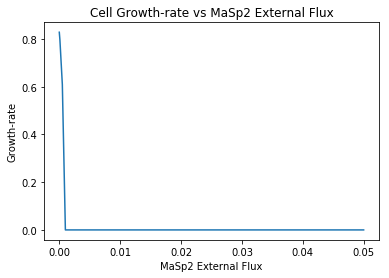

In [24]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp2
# corresponding y axis values
y = growth_rate
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('MaSp2 External Flux')
# naming the y axis
plt.ylabel('Growth-rate')
  
# giving a title to my graph
plt.title('Cell Growth-rate vs MaSp2 External Flux')
  
# function to show the plot
plt.show()

In [25]:
from contextlib import suppress

#me.reactions.DM_protein_MaSp2.upper_bound = 0.00015
#me.reactions.DM_protein_MaSp2.lower_bound = 0.00015
MaSp2 = [0, 0.0001, 0.0005, 0.0006, 0.00061, 0.00062, 0.00063]
growth_rate2 = []
for x in MaSp2:
    print('\nMaSp2 Flux # ',x)
    me.reactions.get_by_id('DM_protein_MaSp2').lower_bound = x
    me.reactions.get_by_id('DM_protein_MaSp2').upper_bound = x
    temp = 0
    with suppress(Exception):
        solve_me_model(me, 1.0, min_mu = .01, precision=1e-2, using_soplex=False)
        temp = me.solution.f    
    growth_rate2.append(temp)
    print('Growth-rate =', growth_rate2)
    
growth_rate2


MaSp2 Flux #  0
iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 35.689793 seconds
Finished substituting S,lb,ub in 2.372488 seconds
Finished makeME_LP in 0.371839 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 2.414979 seconds
Finished makeME_LP in 0.372358 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 2.399801 seconds
Finished makeME_LP in 0.372827 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 2.422055 seconds
Finished makeME_LP in 0.379097 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 2.391869 seconds
Finished makeME_LP in 0.375902 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 2.423612 seconds
Finished makeME_LP in 0.372254 seconds

Finished makeME_LP in 0.359415 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 2.206706 seconds
Finished makeME_LP in 0.366745 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 2.330440 seconds
Finished makeME_LP in 0.368174 seconds
Getting MINOS parameters from ME_NLP...
4 0.0 0.0 0.0625 0.0625 1
Finished substituting S,lb,ub in 2.322154 seconds
Finished makeME_LP in 0.378013 seconds
Getting MINOS parameters from ME_NLP...
5 0.0 0.0 0.03125 0.03125 1
Finished substituting S,lb,ub in 2.322453 seconds
Finished makeME_LP in 0.369859 seconds
Getting MINOS parameters from ME_NLP...
6 0.0 0.0 0.015625 0.015625 1
Finished substituting S,lb,ub in 2.323937 seconds
Finished makeME_LP in 0.363150 seconds
Getting MINOS parameters from ME_NLP...
7 0.0 0.0 0.0078125 0.0078125 1
Bisection done in 510.796 seconds
Growth-rate = [0.828125, 0.796875, 0.609375, 0.5078125, 0, 0, 0]


[0.828125, 0.796875, 0.609375, 0.5078125, 0, 0, 0]

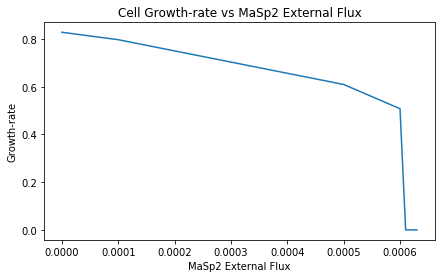

In [27]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp2
# corresponding y axis values
y = growth_rate2

plt.figure(figsize=(7,4))
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('MaSp2 External Flux')
# naming the y axis
plt.ylabel('Growth-rate')
  
# giving a title to my graph
plt.title('Cell Growth-rate vs MaSp2 External Flux')
  
# function to show the plot
plt.show()